## Importar librerias

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import quandl
import investpy

In [2]:
URL_array  = set()
def URL_a_df(URL,nom_col,unir_df,unir=True,verf_col=True,verf_URL = True,limp_URL_array=False,mostrar_detalles=False):
    '''
    Screapea el link y retorna un dataframe
    __________    
    Parametros:
        URL(string): URL a scrapear
        nom_col(string): nombre de la columna para el dataframe
        unir_df(variable)= dataframe con el que el dataframe de salida sera unido a la izquierda segun la fecha                            
        unir(boolean)= Si True,unir, sino, no unir
        verf_col(boolean)= chequea si el nombre de la columna ya existe
        verf_URL(boolean)= chequea si el URL ya se ha procesado 
        limp_URL_array(boolean)= Si True se limpia URL
        mostrar_detalles(boolean)= se imprimen detalles 
        '''
        
    print(f'procesando {nom_col}')

    #clear URL append array
    if limp_URL_array==True:
        URL_array.clear()

    #set unir parameters if false
    if unir == False:
        unir_df = None
        verf_col=False

    #process column name by making it lowercase and replacing spaces,commas, full stops
    nom_col = nom_col.lower().replace(',','').replace(" ", "_").replace(".", "_")

    #nom_col validation if exists already
    if verf_col==True and nom_col in list(unir_df.columns):
        print(f'la columna {nom_col} ya existe en el dataframe, parar aqui')
        return unir_df

    #URL validation if processes already
    elif verf_URL==True and URL in list(URL_array):
        print(f'{URL} ya se proceso, parar aqui')
        return unir_df 

    #web scrapping
    pagina = requests.get(URL)
    ssal = pagina.content
    ssal = str(ssal)
    salida_scrap = (ssal.split('[[')[1]).split('{labels')[0][0:-2]
    if mostrar_detalles == True:
        print('head')
        print({salida_scrap[0:30]})
        print('tail')
        print({salida_scrap[-30:]})
    str_procesado = salida_scrap.replace('new Date(','')
    str_procesado = str_procesado.replace(')','')
    str_procesado = str_procesado.replace('[','')
    str_procesado = str_procesado.replace(']','')
    str_procesado = str_procesado.replace('"','')
    lista_str_procesado = str_procesado.split(',')
    lista_fecha,lista_data = lista_str_procesado[::2],lista_str_procesado[1::2]

    #validate column lengths
    if len(lista_fecha)!=len(lista_data):
        print(f'fecha y longitud de datos:{len(lista_fecha),len(lista_data),len(lista_fecha)==len(lista_data)}')

    #convert list data to a dataframe
    if unir == False:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(lista_fecha)
        df[nom_col] = lista_data
        URL_array.add(URL)
        if mostrar_detalles == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'df shape{df.shape}')
            print('='*100)
            
        return df
    elif nom_col not in list(unir_df.columns) and unir == True:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(lista_fecha)
        df[nom_col] = lista_data
        unir_df = pd.merge(unir_df,df,on=['Date'],how='left')
        URL_array.add(URL)
        if mostrar_detalles == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'shape de df = {df.shape},shape de unir_df = {unir_df.shape}')
            print('='*100)
            print(f'Numero de columnas duplicadas en el dataframe{df.columns.duplicated().sum()}')
            print('='*100)
    
        return unir_df

## Scrapear

### Basicos

In [3]:
df_final = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/01/2013',to_date='19/09/2021')
df_final = df_final.reset_index()
df_final.drop(['Currency','Volume'],inplace=True,axis=1)
df_final.columns = ['Date','opening_price','highest_price','lowest_price','closing_price']
df_final

,Date,opening_price,highest_price,lowest_price,closing_price
0,2013-01-01,13.5,13.6,13.2,13.3
1,2013-01-02,13.3,13.4,13.2,13.3
2,2013-01-03,13.3,13.5,13.3,13.4
3,2013-01-04,13.4,13.5,13.3,13.5
4,2013-01-05,13.5,13.6,13.3,13.4
...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7


### Numero de transacciones en blockchain por dia

In [4]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/bitcoin-transactions.html',
                   'transactions in blockchain',unir_df=df_final,unir=True)

procesando transactions in blockchain


### Tamaño promedio del bloque

In [5]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/size-btc.html',
                   'avg block size',unir_df=df_final,unir=True)

procesando avg block size


### Numero de direcciones unicas por dia

In [6]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/sentbyaddress-btc.html',
                   'sent by adress',unir_df=df_final,unir=True)

procesando sent by adress


### Dificultad promedio de minado por dia

In [7]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/bitcoin-difficulty.html',
                   'avg mining difficulty',unir_df=df_final,unir=True)

procesando avg mining difficulty


### Hashrate promedio por dia

In [8]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/bitcoin-hashrate.html',
                   'avg hashrate',unir_df=df_final,unir=True)

procesando avg hashrate


### Rentabilidad de minado

In [9]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/bitcoin-mining_profitability.html',
                   'mining profitability',unir_df=df_final,unir=True)

procesando mining profitability


### Monedas enviadas

In [10]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/sentinusd-btc.html',
                   'Sent coins in USD',unir_df=df_final,unir=True)

procesando Sent coins in USD


### Tarifas de transaccion

In [11]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/bitcoin-transactionfees.html',
                   'avg transaction fees',unir_df=df_final,unir=True)

procesando avg transaction fees


### Tarifas de transaccion mediana

In [12]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/bitcoin-median_transaction_fee.html',
                   'median transaction fees',unir_df=df_final,unir=True)

procesando median transaction fees


### Tiempo de bloque promedio

In [13]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/bitcoin-confirmationtime.html',
                   'avg block time',unir_df=df_final,unir=True)

procesando avg block time


### Valor de transaccion promedio

In [14]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/transactionvalue-btc.html',
                   'avg transaction value',unir_df=df_final,unir=True)

procesando avg transaction value


### Valor de transaccion mediana

In [15]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/mediantransactionvalue-btc.html',
                   'median transaction value',unir_df=df_final,unir=True)

procesando median transaction value


### Tweets por dia

In [16]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/tweets-btc.html',
                   'tweets',unir_df=df_final,unir=True)

procesando tweets


### Google Trends

In [17]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/google_trends-btc.html',
                   'google trends',unir_df=df_final,unir=True)

procesando google trends


### Numero de direcciones unicas (desde y hacia) por dia

In [18]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/activeaddresses-btc.html',
                   'active addresses',unir_df=df_final,unir=True)

procesando active addresses


### 100 direcciones mas ricas

In [19]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/top100cap-btc.html',
                   'top100 to total percentage',unir_df=df_final,unir=True)

procesando top100 to total percentage


### Porcentaje promedio de tarifas

In [20]:
df_final = URL_a_df('https://bitinfocharts.com/comparison/fee_to_reward-btc.html',
                   'avg fee to reward',unir_df=df_final,unir=True)

procesando avg fee to reward


### Numero total de monedas en circulacion

In [21]:
btc_in_circulation_df = quandl.get("BCHAIN/TOTBC",authtoken='9ztFCcK4_e1xGo_gjzK7')
btc_in_circulation_df = btc_in_circulation_df.rename(columns={'Value': 'number_of_coins_in_circulation'})

### Ingresos de minado

In [22]:
miners_revenue_df = quandl.get("BCHAIN/MIREV",authtoken='9ztFCcK4_e1xGo_gjzK7')
miners_revenue_df = miners_revenue_df.rename(columns={'Value': 'miner_revenue'})

### Additional Features Caracteristicas adicionales

In [23]:
df_final

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_fees,median_transaction_fees,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,0.0107,0.0067,8.889,625.432,14.518,NaN,1.194,37846,19.536,0.627
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,0.0108,0.0066,9.412,650.617,14.514,NaN,1.497,43104,19.597,0.835
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,0.0118,0.00661,8.889,542.73,19.732,NaN,1.798,51268,19.621,0.925
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,0.0105,0.00661,9.412,632.431,11.384,NaN,1.841,47341,19.54,1
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,0.0105,0.00659,10.213,697.556,13.945,NaN,1.826,53417,19.543,0.885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,3.018,0.863,10.141,702497,773.643,109407,89.096,823392,15.186,1.887
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,2.966,0.808,10.588,766989,719.701,90855,86.404,879832,15.185,1.938
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,2.631,0.712,9.796,612387,714.99,101046,81.131,823793,15.177,1.605
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7,227506,563189,424384,18415156832118,1.4285050981775E+20,...,2.457,0.572,9.29,638205,593.076,82649,78.945,701986,15.185,1.183


Filtrar la data segun el periodo

In [24]:
df_final = df_final[(df_final['Date'] >= '2013-01-01')].reset_index(drop=True)

In [25]:
df_final = pd.merge(df_final,btc_in_circulation_df,on=['Date'],how='left')
df_final = pd.merge(df_final,miners_revenue_df,on=['Date'],how='left')
df_final

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_block_time,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,8.889,625.432,14.518,NaN,1.194,37846,19.536,0.627,10621175.00,5.264860e+04
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,9.412,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.00,5.486525e+04
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,8.889,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.00,4.811833e+04
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,9.412,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.00,5.087274e+04
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,10.213,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.00,5.139673e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,10.141,702497,773.643,109407,89.096,823392,15.186,1.887,18816862.50,4.302687e+07
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,10.588,766989,719.701,90855,86.404,879832,15.185,1.938,18817750.00,4.144786e+07
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,9.796,612387,714.99,101046,81.131,823793,15.177,1.605,18818662.50,4.500074e+07
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7,227506,563189,424384,18415156832118,1.4285050981775E+20,...,9.29,638205,593.076,82649,78.945,701986,15.185,1.183,18819693.75,4.781768e+07


In [26]:
df_final['next_day_closing_price'] = df_final['closing_price'].shift(-1)
df_final

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,625.432,14.518,NaN,1.194,37846,19.536,0.627,10621175.00,5.264860e+04,13.3
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.00,5.486525e+04,13.4
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.00,4.811833e+04,13.5
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.00,5.087274e+04,13.4
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.00,5.139673e+04,13.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,702497,773.643,109407,89.096,823392,15.186,1.887,18816862.50,4.302687e+07,47748.0
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,766989,719.701,90855,86.404,879832,15.185,1.938,18817750.00,4.144786e+07,47282.8
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,612387,714.99,101046,81.131,823793,15.177,1.605,18818662.50,4.500074e+07,48306.7
3182,2021-09-18,47283.9,48761.0,47070.5,48306.7,227506,563189,424384,18415156832118,1.4285050981775E+20,...,638205,593.076,82649,78.945,701986,15.185,1.183,18819693.75,4.781768e+07,47238.7


In [27]:
df_final.replace(to_replace='null', value=np.nan,inplace=True)
df_final.drop(df_final.tail(1).index,inplace=True)
df_final

,Date,opening_price,highest_price,lowest_price,closing_price,transactions_in_blockchain,avg_block_size,sent_by_adress,avg_mining_difficulty,avg_hashrate,...,avg_transaction_value,median_transaction_value,tweets,google_trends,active_addresses,top100_to_total_percentage,avg_fee_to_reward,number_of_coins_in_circulation,miner_revenue,next_day_closing_price
0,2013-01-01,13.5,13.6,13.2,13.3,31734,89033,26174,2979637,24331539528899,...,625.432,14.518,NaN,1.194,37846,19.536,0.627,10621175.00,5.264860e+04,13.3
1,2013-01-02,13.3,13.4,13.2,13.3,39280,114077,31809,2979637,22804647966378,...,650.617,14.514,NaN,1.497,43104,19.597,0.835,10621575.00,5.486525e+04,13.4
2,2013-01-03,13.3,13.5,13.3,13.4,42147,108023,38197,2979637,23724885599725,...,542.73,19.732,NaN,1.798,51268,19.621,0.925,10628700.00,4.811833e+04,13.5
3,2013-01-04,13.4,13.5,13.3,13.5,48436,141811,34990,2979637,22608181137438,...,632.431,11.384,NaN,1.841,47341,19.54,1,10632425.00,5.087274e+04,13.4
4,2013-01-05,13.5,13.6,13.3,13.4,39455,118240,38008,2979637,22590695489434,...,697.556,13.945,NaN,1.826,53417,19.543,0.885,10633200.00,5.139673e+04,13.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,2021-09-14,44950.2,47247.6,44718.7,47077.5,267959,599399,491643,18415156832118,1.5551719497901E+20,...,1932378,717.117,91267,90.85,793939,15.218,1.394,18816150.00,4.946986e+07,48130.6
3179,2021-09-15,47070.8,48436.5,46743.9,48130.6,268815,736726,500251,18415156832118,1.3302830209149E+20,...,702497,773.643,109407,89.096,823392,15.186,1.887,18816862.50,4.302687e+07,47748.0
3180,2021-09-16,48132.3,48480.6,47040.3,47748.0,271087,817607,507192,18415156832118,1.302297111233E+20,...,766989,719.701,90855,86.404,879832,15.185,1.938,18817750.00,4.144786e+07,47282.8
3181,2021-09-17,47748.2,48155.9,46788.8,47282.8,270893,720056,499224,18415156832118,1.272835239381E+20,...,612387,714.99,101046,81.131,823793,15.177,1.605,18818662.50,4.500074e+07,48306.7


## Rellenar NaNs

In [28]:
missing_values = pd.DataFrame(df_final.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
tweets,519
active_addresses,22
top100_to_total_percentage,6
avg_block_time,1
Date,0
median_transaction_fees,0
miner_revenue,0
number_of_coins_in_circulation,0
avg_fee_to_reward,0
google_trends,0


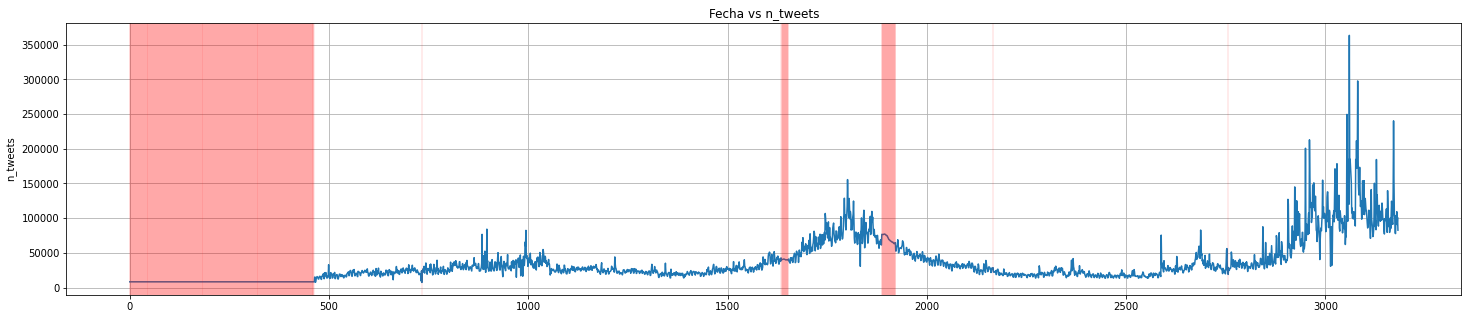

In [29]:
df_final['tweets'].fillna(df_final['tweets'].rolling(40, min_periods=1).mean()).bfill().astype(float).plot(x=df_final['Date'],y='tweets',figsize=(25,5),grid=True)
for i in list(df_final.loc[pd.isna(df_final['tweets']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('n_tweets')
plt.title('Fecha vs n_tweets')
plt.show()
df_final['tweets'] = df_final['tweets'].fillna(df_final['tweets'].rolling(40, min_periods=1).mean()).bfill()

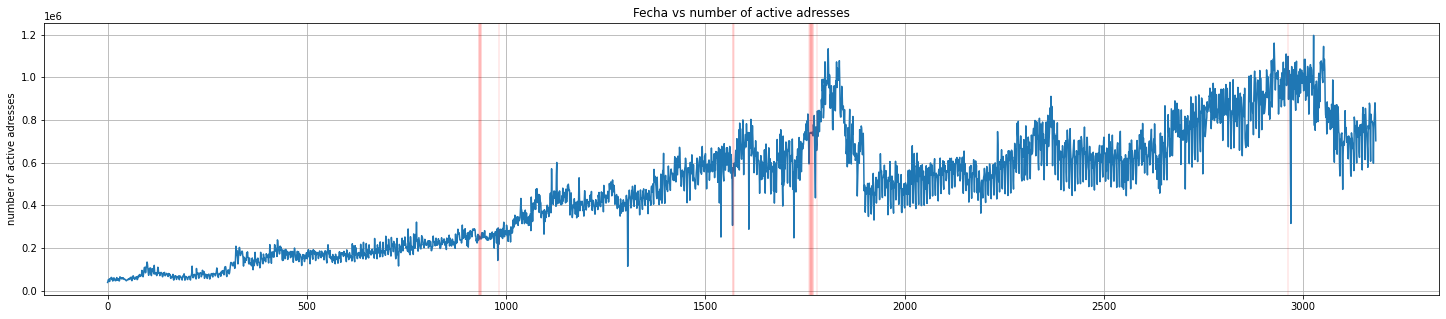

In [30]:
df_final['active_addresses'].fillna(df_final['active_addresses'].rolling(14, min_periods=1).mean()).astype(float).plot(x=df_final['Date'],y='active_addresses',figsize=(25,5),grid=True)
for i in list(df_final.loc[pd.isna(df_final['active_addresses']),:].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('number of active adresses')
plt.title('Fecha vs number of active adresses')
plt.show()
df_final['active_addresses'] = df_final['active_addresses'].fillna(df_final['active_addresses'].rolling(14, min_periods=1).mean())

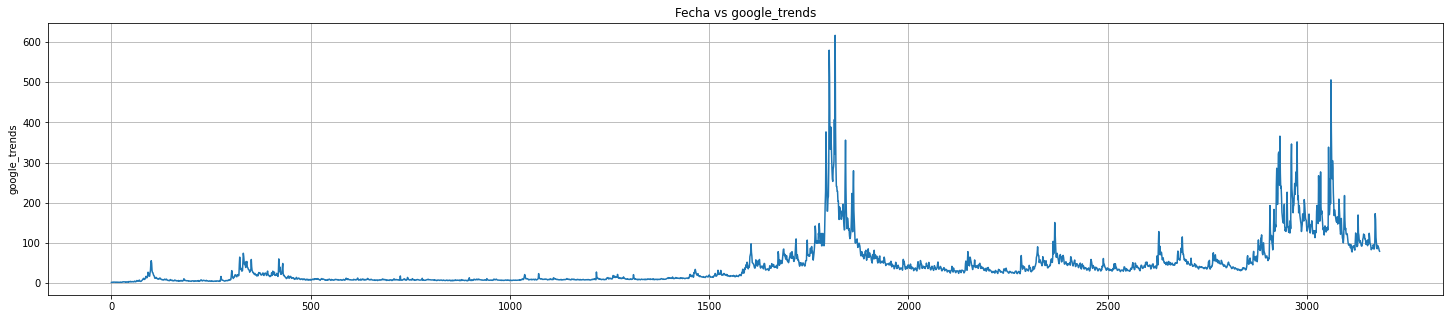

In [31]:
df_final['google_trends'].fillna(df_final['google_trends'].rolling(14, min_periods=1).mean()).astype(float).plot(x=df_final['Date'],y='google_trends',figsize=(25,5),grid=True)
for i in list(df_final.loc[pd.isna(df_final['google_trends']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('google_trends')
plt.title('Fecha vs google_trends')
plt.show()
df_final['google_trends'] = df_final['google_trends'].fillna(df_final['google_trends'].rolling(14, min_periods=1).mean())

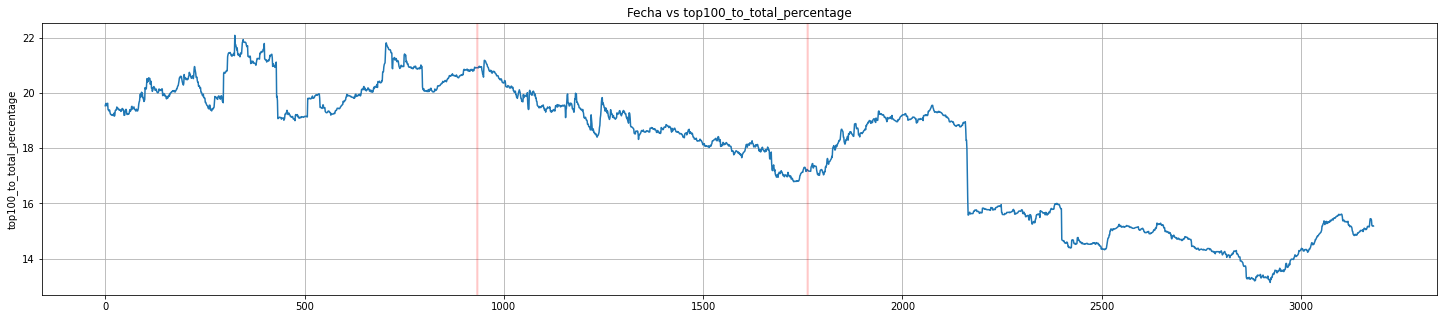

In [32]:
df_final['top100_to_total_percentage'].fillna(df_final['top100_to_total_percentage'].rolling(7, min_periods=1).mean()).astype(float).plot(x=df_final['Date'],y='top100_to_total_percentage',figsize=(25,5),grid=True)
for i in list(df_final.loc[pd.isna(df_final['top100_to_total_percentage']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('top100_to_total_percentage')
plt.title('Fecha vs top100_to_total_percentage')
plt.show()
df_final['top100_to_total_percentage'] = df_final['top100_to_total_percentage'].fillna(df_final['top100_to_total_percentage'].rolling(7, min_periods=1).mean())

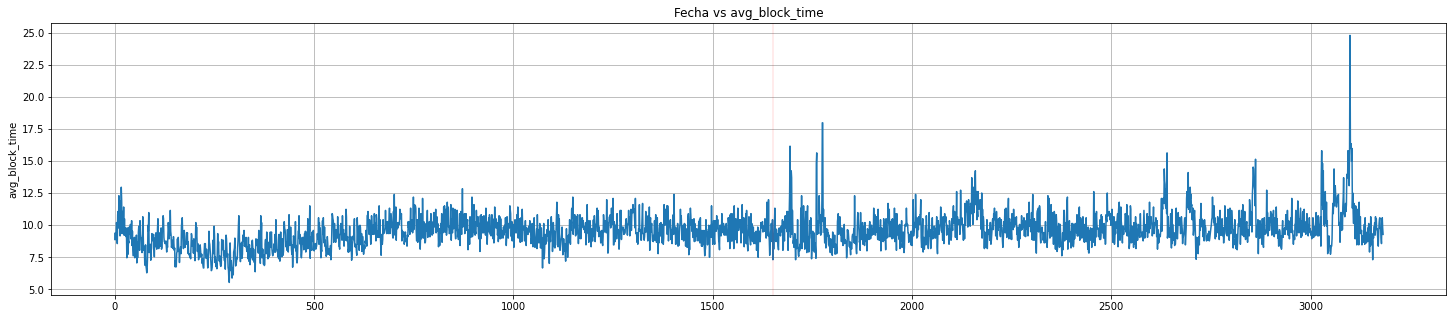

In [33]:
df_final['avg_block_time'].fillna(df_final['avg_block_time'].rolling(7, min_periods=1).mean()).astype(float).plot(x=df_final['Date'],y='avg_block_time',figsize=(25,5),grid=True)
for i in list(df_final.loc[pd.isna(df_final['avg_block_time']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('avg_block_time')
plt.title('Fecha vs avg_block_time')
plt.show()
df_final['avg_block_time'] = df_final['avg_block_time'].fillna(df_final['avg_block_time'].rolling(7, min_periods=1).mean())

In [34]:
missing_values = pd.DataFrame(df_final.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

,missing_count
Date,0
median_transaction_fees,0
miner_revenue,0
number_of_coins_in_circulation,0
avg_fee_to_reward,0
top100_to_total_percentage,0
active_addresses,0
google_trends,0
tweets,0
median_transaction_value,0


In [36]:
df_final.to_csv('data_final_rellenada.csv',index=False)